In [50]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt

# prepare the data

In [2]:
# Load the dataset
data = pd.read_csv('weather_prediction_dataset.csv')

In [3]:
# print data
data

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [4]:
# select features
features = ['DATE', 'TOURS_temp_max', 'TOURS_temp_min', 'TOURS_temp_mean','TOURS_global_radiation']
data = data[features]

In [5]:
# converting the 'DATE' column in the DataFrame 'data' to datetime format
data.loc[:, 'DATE'] = pd.to_datetime(data.loc[:, 'DATE'])

<ipython-input-5-7695870f3aa5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'DATE'] = pd.to_datetime(data.loc[:, 'DATE'])


In [6]:
# print data
data

,DATE,TOURS_temp_max,TOURS_temp_min,TOURS_temp_mean,TOURS_global_radiation
0,1970-01-01 00:00:00.020000101,9.8,7.2,8.5,0.25
1,1970-01-01 00:00:00.020000102,9.2,6.6,7.9,0.17
2,1970-01-01 00:00:00.020000103,9.6,6.6,8.1,0.27
3,1970-01-01 00:00:00.020000104,10.8,6.4,8.6,0.11
4,1970-01-01 00:00:00.020000105,9.5,6.4,8.0,0.39
...,...,...,...,...,...
3649,1970-01-01 00:00:00.020091228,10.6,1.8,6.2,0.22
3650,1970-01-01 00:00:00.020091229,14.5,6.2,10.4,0.24
3651,1970-01-01 00:00:00.020091230,11.3,8.7,10.0,0.24
3652,1970-01-01 00:00:00.020091231,10.9,6.2,8.5,0.58


In [7]:
# divide the data

# Dates from 2000 to 2007 used for training your model
train_set = data[(data['DATE'] >= '1970-01-01 00:00:00.020000101') & (data['DATE'] < '1970-01-01 00:00:00.020080101')]

# Dates from 2008 and 2009 used to validate your model
val_set = data[(data['DATE'] >= '1970-01-01 00:00:00.020080101') & (data['DATE'] < '1970-01-01 00:00:00.020100101')]

In [8]:
# Define the features and target variables
features = ['TOURS_temp_min', 'TOURS_temp_mean','TOURS_global_radiation']
target = 'TOURS_temp_max'

# Extract the features and target values from the training set
X_train = train_set[features].values
y_train = train_set[target].values

# Extract the features and target values from the validation set
X_val = val_set[features].values
y_val = val_set[target].values

In [9]:
print(f'''X_train shape : {X_train.shape}
y_train shape : {y_train.shape}
X_val shape : {X_val.shape}
y_val shape : {y_val.shape}''')

X_train shape : (2922, 3)
y_train shape : (2922,)
X_val shape : (731, 3)
y_val shape : (731,)


In [10]:
# applay 3 timesteps using slaid window on featurs data
# Define different time steps for creating input sequences
timesteps = [1, 25, 100]

# Create input sequences with the first time step
X_train_1 = np.zeros((X_train.shape[0] - timesteps[0] + 1, timesteps[0], X_train.shape[1]))
for i in range(timesteps[0]):
  X_train_1[:, i, :] = X_train[i:X_train.shape[0] - timesteps[0] + i + 1, :]

X_val_1 = np.zeros((X_val.shape[0] - timesteps[0] + 1, timesteps[0], X_val.shape[1]))
for i in range(timesteps[0]):
  X_val_1[:, i, :] = X_val[i:X_val.shape[0] - timesteps[0] + i + 1, :]

# Create input sequences with the second time step
X_train_2 = np.zeros((X_train.shape[0] - timesteps[1] + 1, timesteps[1], X_train.shape[1]))
for i in range(timesteps[1]):
  X_train_2[:, i, :] = X_train[i:X_train.shape[0] - timesteps[1] + i + 1, :]

X_val_2 = np.zeros((X_val.shape[0] - timesteps[1] + 1, timesteps[1], X_val.shape[1]))
for i in range(timesteps[1]):
  X_val_2[:, i, :] = X_val[i:X_val.shape[0] - timesteps[1] + i + 1, :]

# Create input sequences with the third time step
X_train_3 = np.zeros((X_train.shape[0] - timesteps[2] + 1, timesteps[2], X_train.shape[1]))
for i in range(timesteps[2]):
  X_train_3[:, i, :] = X_train[i:X_train.shape[0] - timesteps[2] + i + 1, :]

X_val_3 = np.zeros((X_val.shape[0] - timesteps[2] + 1, timesteps[2], X_val.shape[1]))
for i in range(timesteps[2]):
  X_val_3[:, i, :] = X_val[i:X_val.shape[0] - timesteps[2] + i + 1, :]


In [11]:
# applay 3 timesteps using slaid window on labels data

# Create input sequences with the first time step
y_train_1 = y_train[timesteps[0] - 1:]
y_val_1 = y_val[timesteps[0] - 1:]

# Create input sequences with the second time step
y_train_2 = y_train[timesteps[1] - 1:]
y_val_2 = y_val[timesteps[1] - 1:]

# Create input sequences with the third time step
y_train_3 = y_train[timesteps[2] - 1:]
y_val_3 = y_val[timesteps[2] - 1:]

In [12]:
# Train each model with early stopping
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

# RNN Models

In [16]:
# first model
rnn_model_1 = Sequential()

# add layers
rnn_model_1.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
rnn_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_1 = rnn_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 2s 6ms/step - loss: 278.8764 - val_loss: 200.5069
Epoch 2/500
92/92 [==============================] - 0s 4ms/step - loss: 155.0850 - val_loss: 114.2816
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 102.7842 - val_loss: 80.2356
Epoch 4/500
92/92 [==============================] - 0s 4ms/step - loss: 74.8012 - val_loss: 58.6821
Epoch 5/500
92/92 [==============================] - 0s 4ms/step - loss: 56.5753 - val_loss: 44.3033
Epoch 6/500
92/92 [==============================] - 0s 4ms/step - loss: 44.0582 - val_loss: 34.2045
Epoch 7/500
92/92 [==============================] - 0s 4ms/step - loss: 34.5937 - val_loss: 26.4393
Epoch 8/500
92/92 [==============================] - 0s 4ms/step - loss: 27.5037 - val_loss: 20.7868
Epoch 9/500
92/92 [==============================] - 0s 4ms/step - loss: 22.1866 - val_loss: 16.6145
Epoch 10/500
92/92 [==============================] - 0s 5ms/step - loss: 18.1837 - va

In [48]:
# predict validtion data
y_hat = rnn_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 0s 4ms/step


(731, 1)

In [49]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_rnn_1

0.00665151

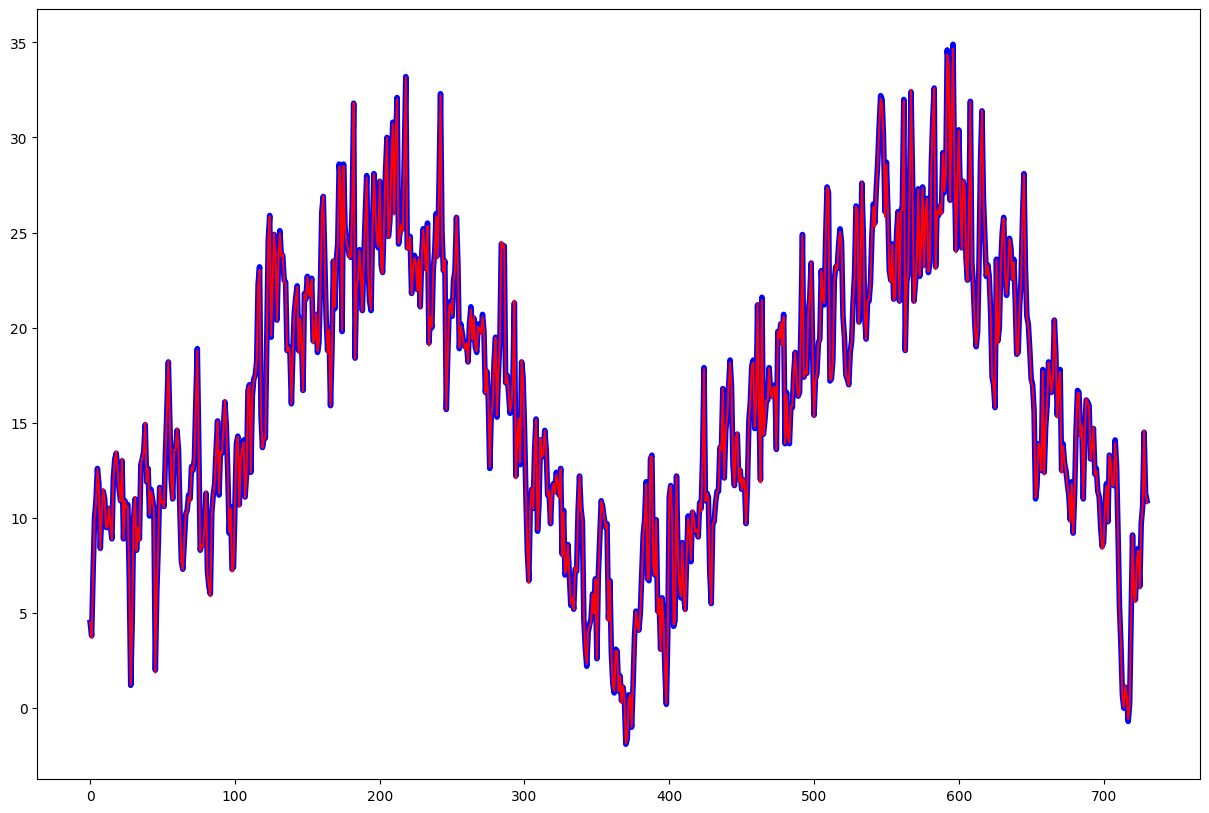

In [61]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [22]:
# second model
rnn_model_2 = Sequential()

# add layers
rnn_model_2.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
rnn_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_2 = rnn_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 3s 26ms/step - loss: 186.8748 - val_loss: 122.2654
Epoch 2/500
91/91 [==============================] - 2s 18ms/step - loss: 101.7381 - val_loss: 79.3508
Epoch 3/500
91/91 [==============================] - 2s 18ms/step - loss: 71.3782 - val_loss: 55.5514
Epoch 4/500
91/91 [==============================] - 2s 18ms/step - loss: 51.1577 - val_loss: 39.1376
Epoch 5/500
91/91 [==============================] - 2s 19ms/step - loss: 36.9403 - val_loss: 27.5662
Epoch 6/500
91/91 [==============================] - 2s 17ms/step - loss: 26.9653 - val_loss: 19.7498
Epoch 7/500
91/91 [==============================] - 2s 24ms/step - loss: 20.0956 - val_loss: 14.3764
Epoch 8/500
91/91 [==============================] - 3s 37ms/step - loss: 15.2893 - val_loss: 10.6096
Epoch 9/500
91/91 [==============================] - 2s 23ms/step - loss: 11.8789 - val_loss: 8.0073
Epoch 10/500
91/91 [==============================] - 2s 25ms/step - loss: 9.409

In [62]:
# predict validtion data
y_hat = rnn_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 6ms/step


(707, 1)

In [64]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_rnn_2

0.012360777

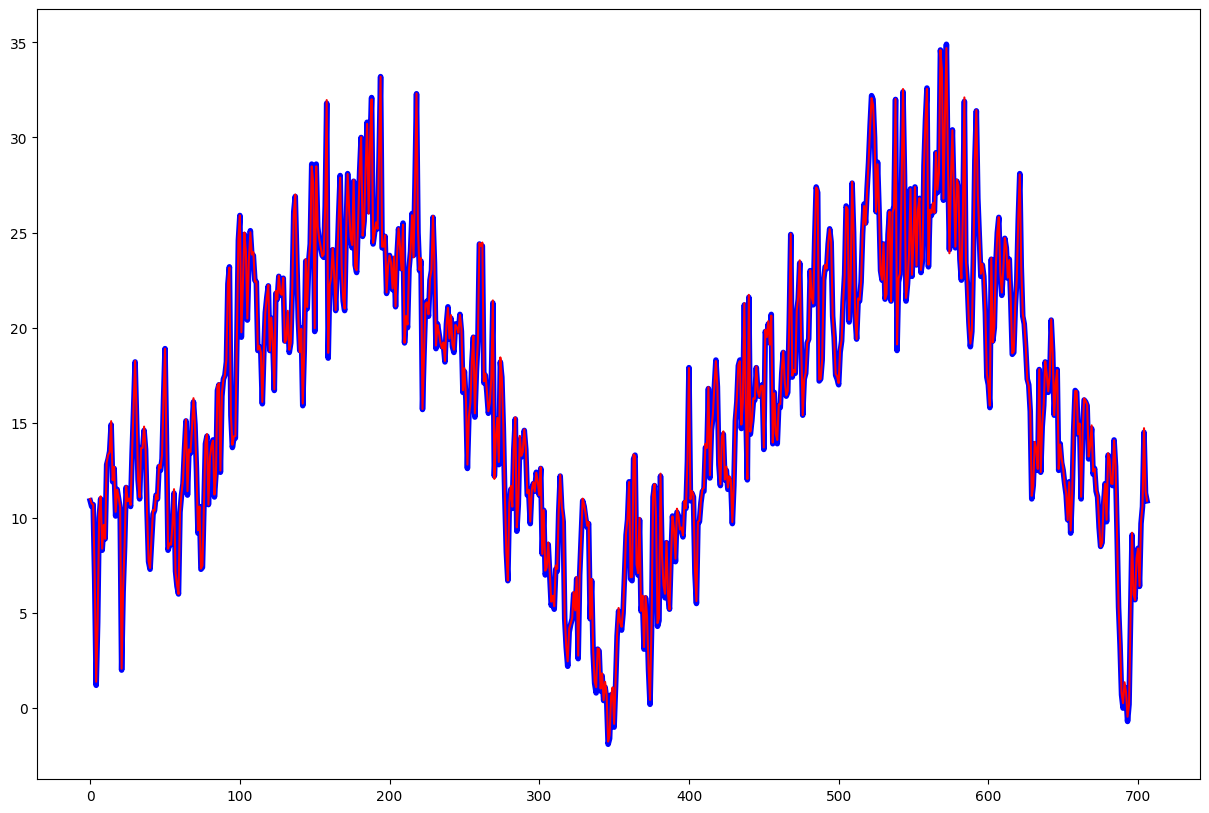

In [66]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [25]:
# third model
rnn_model_3 = Sequential()

# add layers
rnn_model_3.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
rnn_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_3 = rnn_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 7s 75ms/step - loss: 296.7501 - val_loss: 216.1849
Epoch 2/500
89/89 [==============================] - 5s 61ms/step - loss: 161.7910 - val_loss: 130.7086
Epoch 3/500
89/89 [==============================] - 7s 79ms/step - loss: 107.9539 - val_loss: 94.5926
Epoch 4/500
89/89 [==============================] - 6s 64ms/step - loss: 79.7332 - val_loss: 69.1702
Epoch 5/500
89/89 [==============================] - 7s 75ms/step - loss: 59.3875 - val_loss: 50.7973
Epoch 6/500
89/89 [==============================] - 6s 62ms/step - loss: 44.3918 - val_loss: 37.4658
Epoch 7/500
89/89 [==============================] - 7s 74ms/step - loss: 33.6385 - val_loss: 27.8008
Epoch 8/500
89/89 [==============================] - 6s 62ms/step - loss: 25.7796 - val_loss: 20.8419
Epoch 9/500
89/89 [==============================] - 6s 71ms/step - loss: 20.1010 - val_loss: 15.8804
Epoch 10/500
89/89 [==============================] - 6s 63ms/step - loss: 15

In [67]:
# predict validtion data
y_hat = rnn_model_3.predict(X_val_3)
y_hat.shape

20/20 [==============================] - 0s 15ms/step


(632, 1)

In [68]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_rnn_3

0.012281585

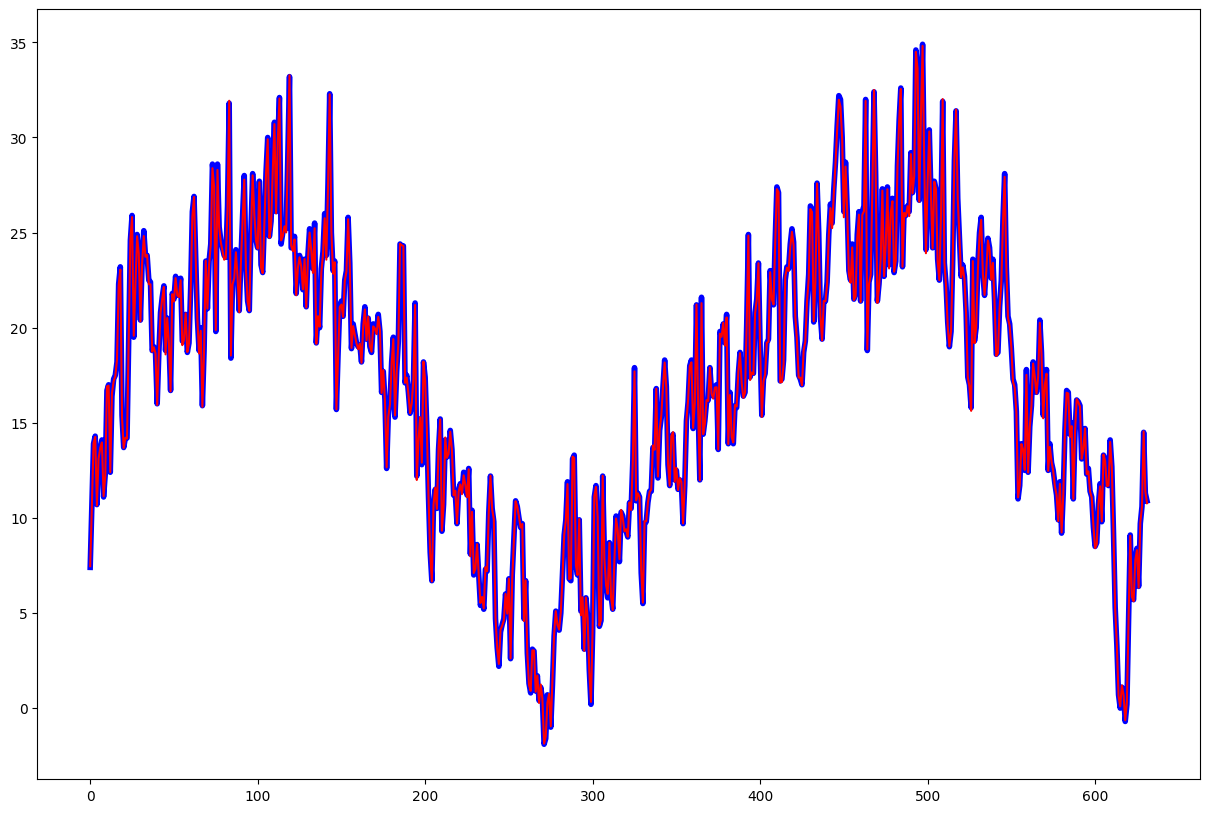

In [69]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# LSTM Models

In [29]:
# first model
lstm_model_1 = Sequential()

#compile the model
lstm_model_1.add(LSTM(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
lstm_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_1 = lstm_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 2s 10ms/step - loss: 283.5707 - val_loss: 216.9097
Epoch 2/500
92/92 [==============================] - 0s 4ms/step - loss: 164.4661 - val_loss: 111.6663
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 95.0486 - val_loss: 69.2333
Epoch 4/500
92/92 [==============================] - 0s 4ms/step - loss: 61.8261 - val_loss: 44.9995
Epoch 5/500
92/92 [==============================] - 0s 5ms/step - loss: 43.1217 - val_loss: 32.3818
Epoch 6/500
92/92 [==============================] - 0s 4ms/step - loss: 32.3364 - val_loss: 24.1440
Epoch 7/500
92/92 [==============================] - 0s 4ms/step - loss: 25.0965 - val_loss: 18.5800
Epoch 8/500
92/92 [==============================] - 0s 4ms/step - loss: 19.8628 - val_loss: 14.4824
Epoch 9/500
92/92 [==============================] - 0s 5ms/step - loss: 16.0414 - val_loss: 11.7165
Epoch 10/500
92/92 [==============================] - 1s 7ms/step - loss: 13.3450 - va

In [70]:
# predict validtion data
y_hat = lstm_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(731, 1)

In [71]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_lstm_1

0.0071230554

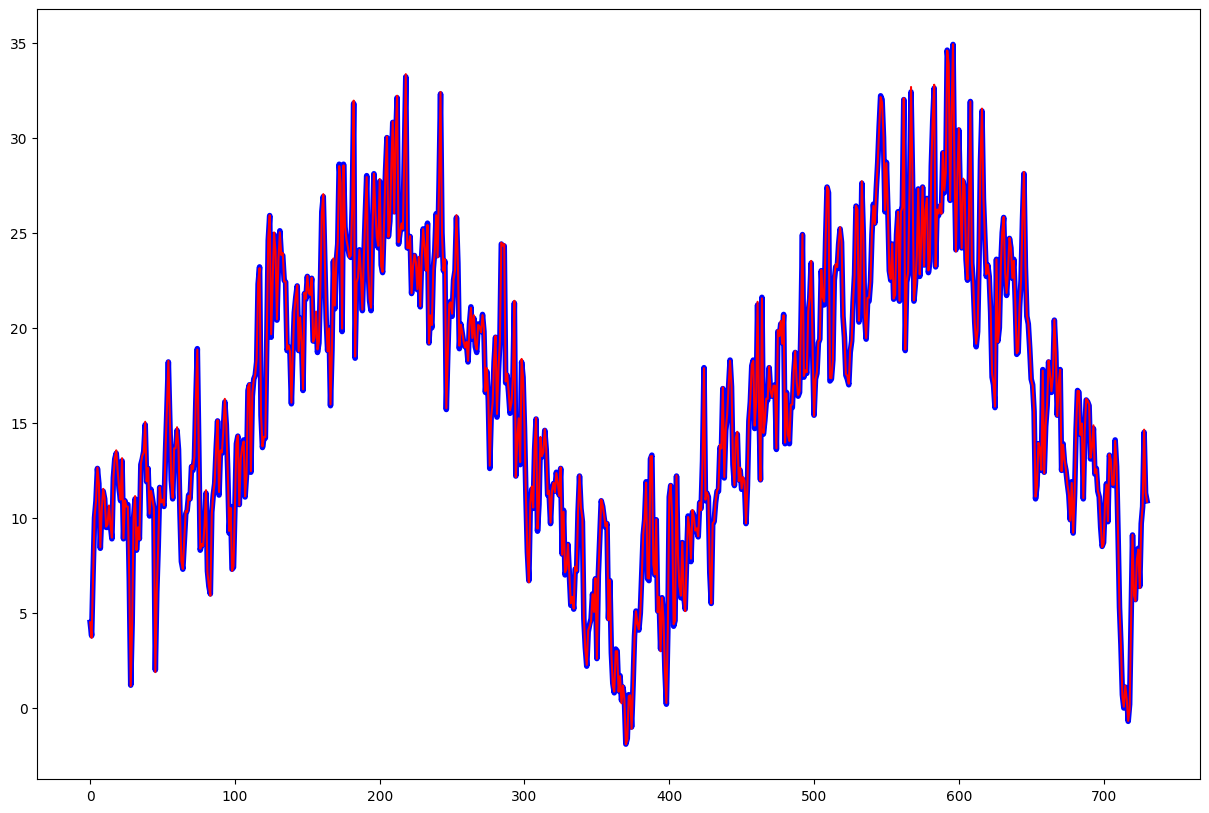

In [72]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [32]:
# second model
lstm_model_2 = Sequential()

#compile the model
lstm_model_2.add(LSTM(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
lstm_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_2 = lstm_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 3s 13ms/step - loss: 257.0020 - val_loss: 168.2127
Epoch 2/500
91/91 [==============================] - 1s 8ms/step - loss: 132.2321 - val_loss: 98.2133
Epoch 3/500
91/91 [==============================] - 1s 7ms/step - loss: 83.4939 - val_loss: 63.6671
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 57.4993 - val_loss: 43.9339
Epoch 5/500
91/91 [==============================] - 0s 5ms/step - loss: 41.0060 - val_loss: 30.9009
Epoch 6/500
91/91 [==============================] - 0s 5ms/step - loss: 29.9117 - val_loss: 22.1923
Epoch 7/500
91/91 [==============================] - 0s 5ms/step - loss: 22.3038 - val_loss: 16.1461
Epoch 8/500
91/91 [==============================] - 0s 5ms/step - loss: 17.0378 - val_loss: 12.0141
Epoch 9/500
91/91 [==============================] - 0s 5ms/step - loss: 13.2935 - val_loss: 9.2046
Epoch 10/500
91/91 [==============================] - 0s 5ms/step - loss: 10.6023 - val_

In [73]:
# predict validtion data
y_hat = lstm_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(707, 1)

In [74]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_lstm_2

0.009208436

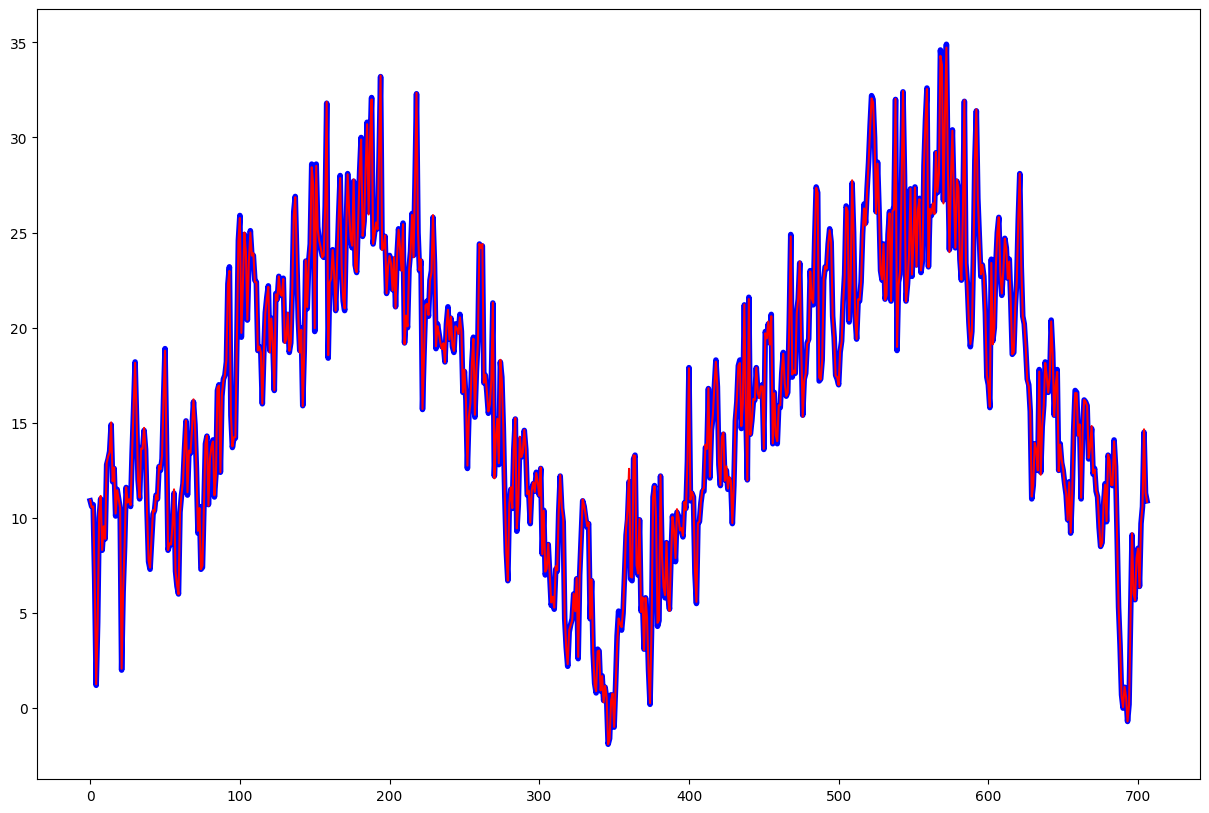

In [75]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [35]:
# third model
lstm_model_3 = Sequential()

#compile the model
lstm_model_3.add(LSTM(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
lstm_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_3 = lstm_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 3s 16ms/step - loss: 286.5386 - val_loss: 205.4568
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 146.4466 - val_loss: 108.3550
Epoch 3/500
89/89 [==============================] - 1s 8ms/step - loss: 86.3818 - val_loss: 70.4686
Epoch 4/500
89/89 [==============================] - 1s 6ms/step - loss: 58.6503 - val_loss: 48.4037
Epoch 5/500
89/89 [==============================] - 1s 7ms/step - loss: 41.7543 - val_loss: 34.2212
Epoch 6/500
89/89 [==============================] - 1s 6ms/step - loss: 30.5730 - val_loss: 24.6985
Epoch 7/500
89/89 [==============================] - 1s 7ms/step - loss: 22.9981 - val_loss: 18.0843
Epoch 8/500
89/89 [==============================] - 1s 7ms/step - loss: 17.6766 - val_loss: 13.6577
Epoch 9/500
89/89 [==============================] - 1s 7ms/step - loss: 13.8998 - val_loss: 10.4152
Epoch 10/500
89/89 [==============================] - 1s 7ms/step - loss: 11.1364 - v

In [76]:
# predict validtion data
y_hat = lstm_model_3.predict(X_val_3)
y_hat.shape

20/20 [==============================] - 0s 3ms/step


(632, 1)

In [77]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_lstm_3

0.008785325

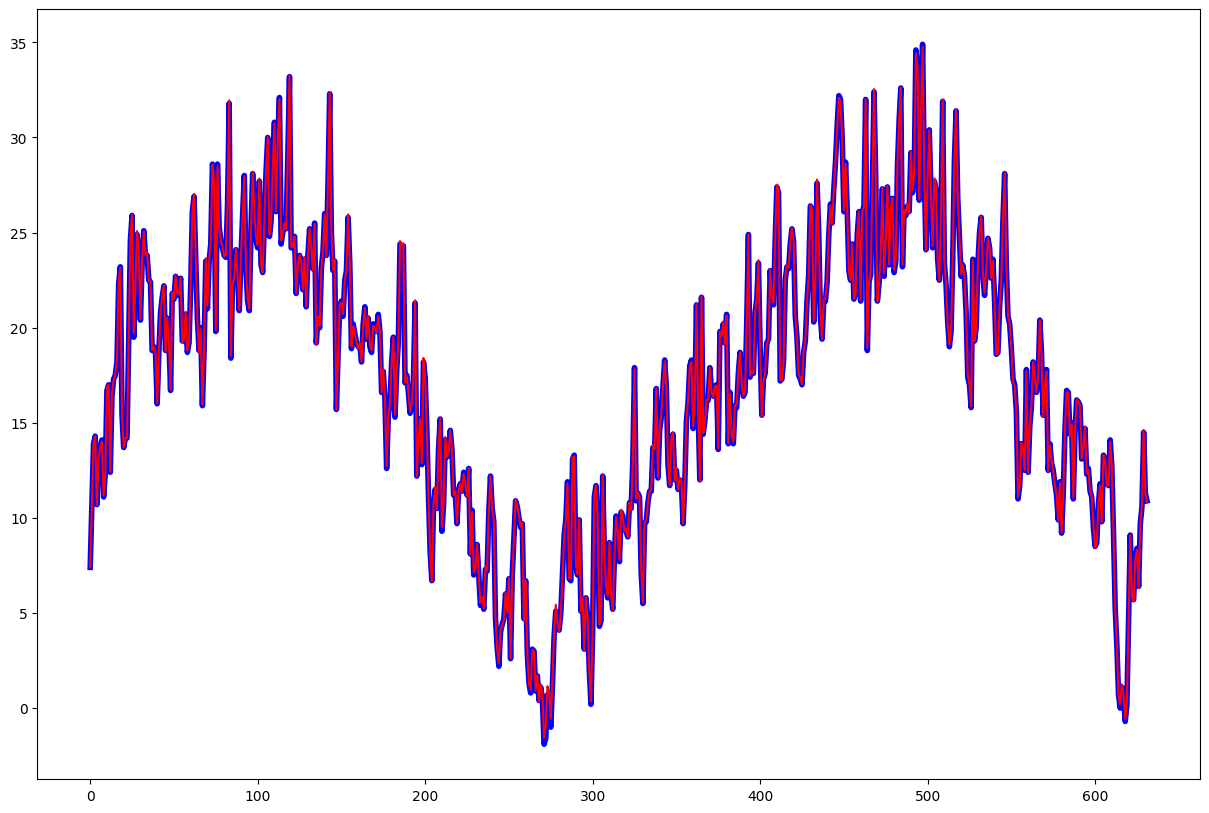

In [78]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# GRU Models

In [39]:
# first model
gru_model_1 = Sequential()

#compile the model
gru_model_1.add(GRU(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
gru_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_1 = gru_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 2s 9ms/step - loss: 237.3637 - val_loss: 175.0184
Epoch 2/500
92/92 [==============================] - 0s 4ms/step - loss: 137.6199 - val_loss: 97.3471
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 82.8059 - val_loss: 59.6037
Epoch 4/500
92/92 [==============================] - 0s 4ms/step - loss: 53.8547 - val_loss: 38.4124
Epoch 5/500
92/92 [==============================] - 0s 4ms/step - loss: 37.2942 - val_loss: 27.5818
Epoch 6/500
92/92 [==============================] - 0s 4ms/step - loss: 27.9417 - val_loss: 20.4097
Epoch 7/500
92/92 [==============================] - 0s 4ms/step - loss: 21.3304 - val_loss: 15.2791
Epoch 8/500
92/92 [==============================] - 0s 4ms/step - loss: 16.5655 - val_loss: 11.7407
Epoch 9/500
92/92 [==============================] - 0s 4ms/step - loss: 13.1837 - val_loss: 9.2699
Epoch 10/500
92/92 [==============================] - 0s 4ms/step - loss: 10.7847 - val_l

In [79]:
# predict validtion data
y_hat = gru_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(731, 1)

In [80]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_gru_1

0.0061478904

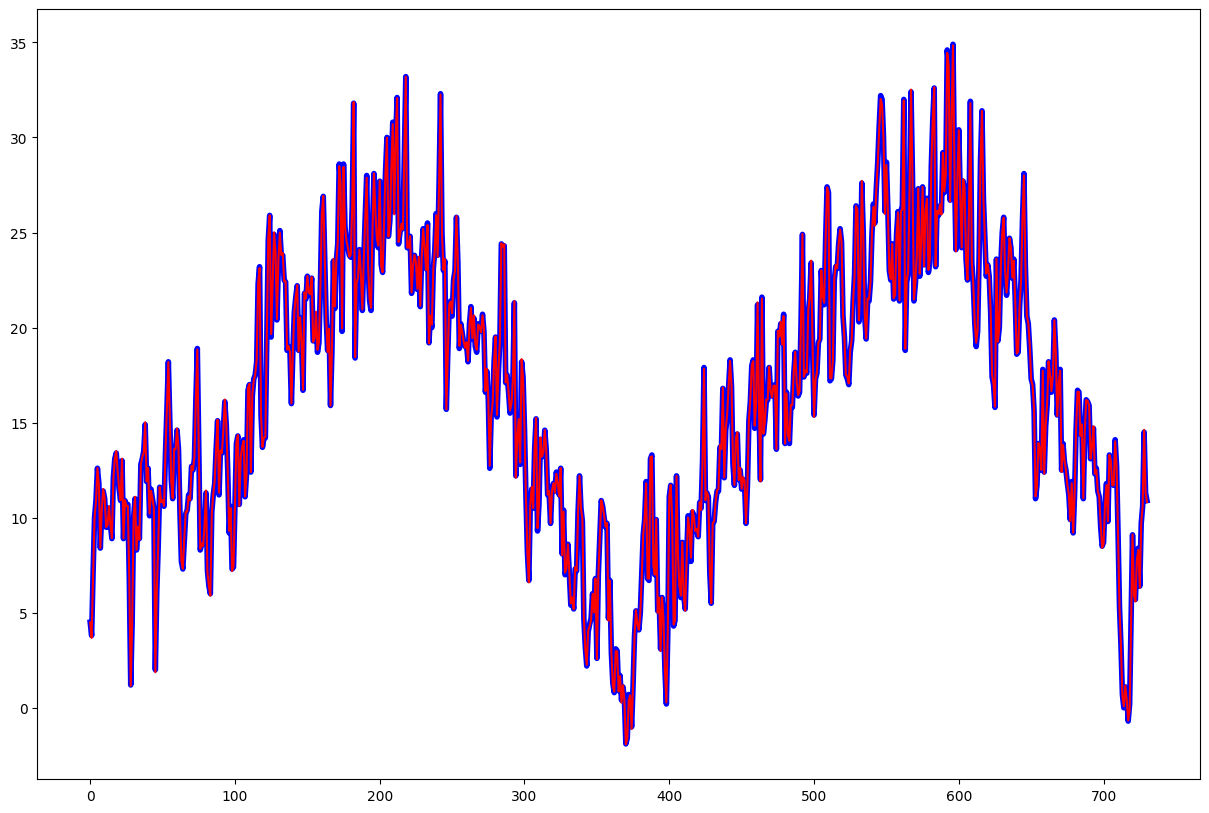

In [81]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [42]:
# second model
gru_model_2 = Sequential()

#compile the model
gru_model_2.add(GRU(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
gru_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_2 = gru_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 3s 10ms/step - loss: 261.6397 - val_loss: 139.6749
Epoch 2/500
91/91 [==============================] - 0s 5ms/step - loss: 113.9001 - val_loss: 87.7095
Epoch 3/500
91/91 [==============================] - 0s 5ms/step - loss: 78.3510 - val_loss: 61.1151
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 55.7325 - val_loss: 43.0303
Epoch 5/500
91/91 [==============================] - 0s 5ms/step - loss: 40.0807 - val_loss: 30.3293
Epoch 6/500
91/91 [==============================] - 0s 5ms/step - loss: 29.0181 - val_loss: 21.5141
Epoch 7/500
91/91 [==============================] - 0s 5ms/step - loss: 21.4839 - val_loss: 15.4988
Epoch 8/500
91/91 [==============================] - 0s 5ms/step - loss: 16.2419 - val_loss: 11.4544
Epoch 9/500
91/91 [==============================] - 0s 5ms/step - loss: 12.5221 - val_loss: 8.5230
Epoch 10/500
91/91 [==============================] - 0s 5ms/step - loss: 9.8414 - val_l

In [82]:
# predict validtion data
y_hat = gru_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(707, 1)

In [83]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_gru_2

0.008443679

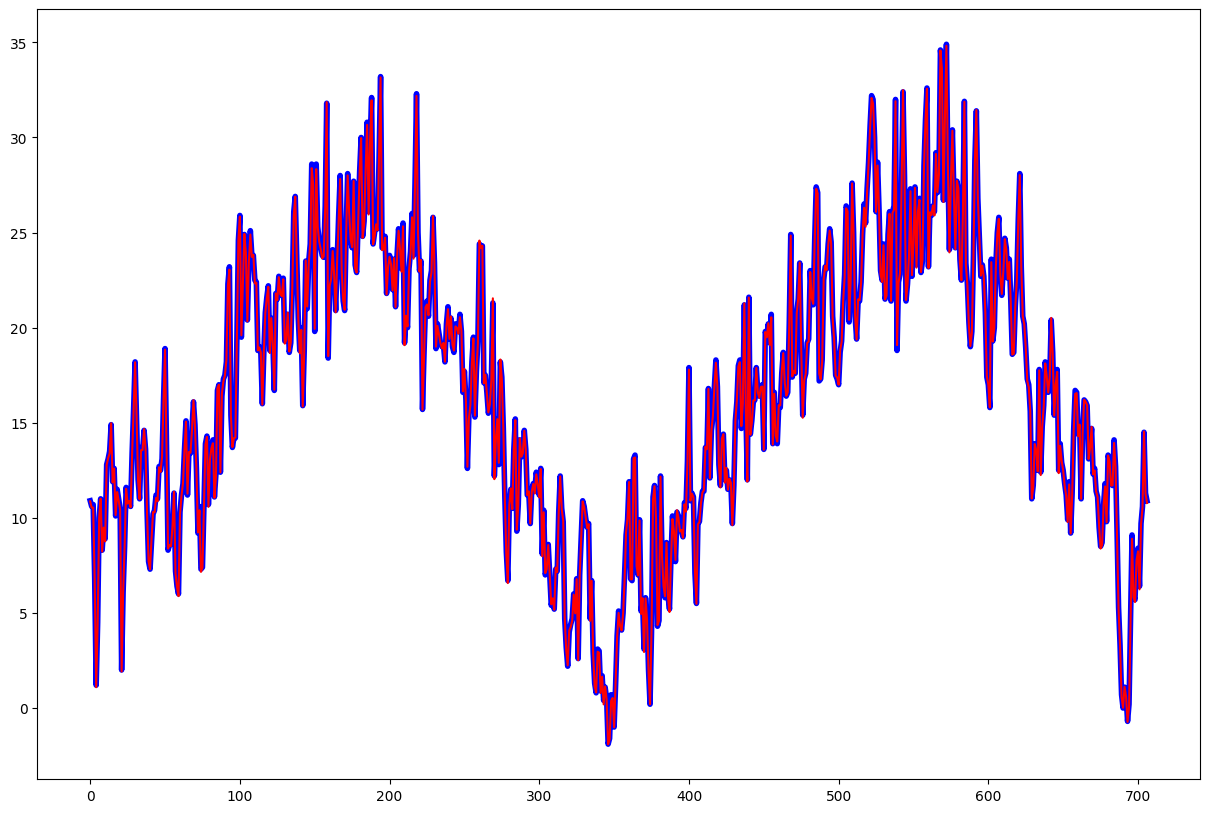

In [84]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [45]:
# third model
gru_model_3 = Sequential()

#compile the model
gru_model_3.add(GRU(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
gru_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_3 = gru_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 3s 12ms/step - loss: 251.4794 - val_loss: 144.3536
Epoch 2/500
89/89 [==============================] - 1s 6ms/step - loss: 111.2064 - val_loss: 92.2777
Epoch 3/500
89/89 [==============================] - 1s 6ms/step - loss: 76.2526 - val_loss: 64.6308
Epoch 4/500
89/89 [==============================] - 1s 6ms/step - loss: 54.7562 - val_loss: 45.6769
Epoch 5/500
89/89 [==============================] - 1s 6ms/step - loss: 39.5639 - val_loss: 32.3766
Epoch 6/500
89/89 [==============================] - 1s 6ms/step - loss: 28.9442 - val_loss: 23.1293
Epoch 7/500
89/89 [==============================] - 1s 6ms/step - loss: 21.5944 - val_loss: 16.8671
Epoch 8/500
89/89 [==============================] - 1s 6ms/step - loss: 16.4966 - val_loss: 12.5489
Epoch 9/500
89/89 [==============================] - 1s 7ms/step - loss: 12.8211 - val_loss: 9.4055
Epoch 10/500
89/89 [==============================] - 1s 7ms/step - loss: 10.1081 - val_

In [85]:
# predict validtion data
y_hat = gru_model_3.predict(X_val_3)
y_hat.shape

20/20 [==============================] - 0s 3ms/step


(632, 1)

In [86]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_gru_3

0.00776523

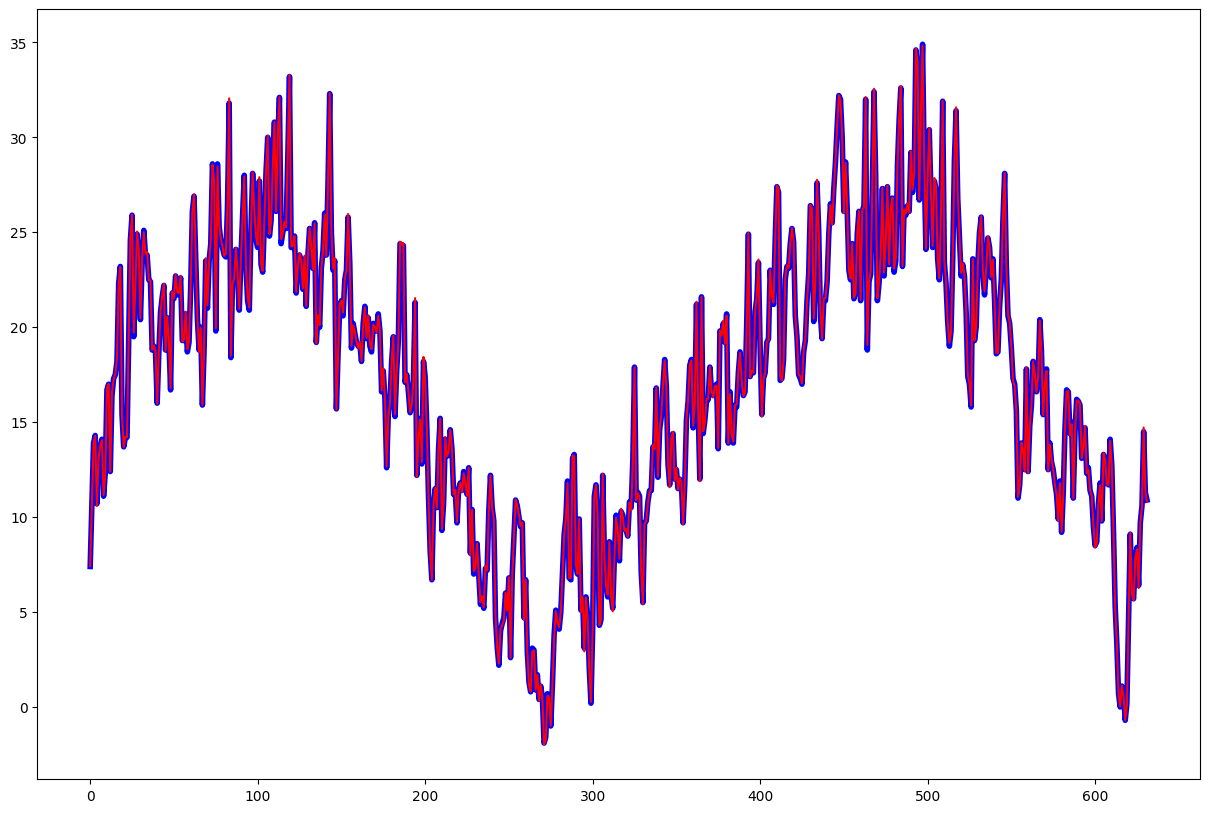

In [88]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# conclusion

In [89]:
# from tabulate import tabulate

# detials = [
#     ,[1,195,,, 99]
#     ,[25,160,, 91]
#     ,[100,130,, 94]]
# headers = ["Step Size","# of epochs","RNN val loss","LSTM val loss", "GRU val loss"]